---

# Mastère Spécialisé Expert en Science des données

---
## TRAITEMENT DE DONNEES MASSIVES AVEC PYSPARK
---

*Auteur :* Paquarse Mahouvi

*Date:* 01-06-2024
---

# Introduction
L'objectif de ce projet est de prendre en main l'utilisation et les bonne pratiques de Pyspark, nous nous sommes inspirer de la documentation officielle de Spark Apache disponible sur [le lien de Spark Apache](https://spark.apache.org/docs/latest/index.html) et plus précisement sur la bibliothèque [Mlib](https://spark.apache.org/docs/latest/ml-guide.html). Nous avons opté également pour un dévéloppement en local afin de rencontrer les problèmes pouvant subvenir lors de l'utilisation de pyspark en local plutôt qu'une utilisation de collab ou encore kaggle. Ainsi, nous avons eu à installer divers librairies (notamment pyspark et findspark), mais aussi **java** en local afin d'utiliser l'interface graphique **Spark Web UI**

<img src="/content/gdrive/MyDrive/Spark/interface.pngg">

Le choix des algorithmes de classification n'a pas également été fait selon une logique particulière, mais également de la possibilité d'impléter plusieurs algorithmes différents afin de comprendre comme ils tournent sur spark même si le principe reste le même.

# Importation des libraires

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c68c85b728ffb5e79df98193b3508572f73907a2c6b98aaa68cd81386385373c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
pip install findspark

In [6]:
import pyspark
import findspark
import pandas as pd
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql import functions as fn
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, StopWordsRemover,Word2Vec, RegexTokenizer, OneHotEncoder, VectorAssembler, CountVectorizer, SQLTransformer
from pyspark.sql.functions import col, count, countDistinct, when, isnan, expr, lower, regexp_replace, trim, split, explode
from pyspark.sql.types import StringType, StructField, StructType, LongType
from pyspark.ml import Pipeline

Les opérations pour passer de spark as un dataframe pandas enlenche la récupération et le processus sur l'ordinateur. Il sera donc éviter au maximum.

In [7]:
sc = SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [8]:
spark = SparkSession.builder \
    .appName("Pâquarse Mahouvi") \
    .getOrCreate()

spark

In [9]:
from google.colab import output
output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

<IPython.core.display.Javascript object>

In [10]:
df_train = spark.read.option("inferSchema", True).json("/content/gdrive/MyDrive/Spark/train.json")
df_test = spark.read.option("inferSchema", True).json("/content/gdrive/MyDrive/Spark/test.json")

In [11]:
df_train.printSchema()
df_test.printSchema()
df_train.show(5)

root
 |-- message: string (nullable = true)
 |-- polarity: string (nullable = true)

root
 |-- message: string (nullable = true)
 |-- polarity: string (nullable = true)

+--------------------+--------+
|             message|polarity|
+--------------------+--------+
|! Comment était l...|       0|
|! d'accord! Va-t-...|       0|
|!!! Taihen desu n...|       0|
|!!!! Auto-dj .. c...|       0|
|!!!! Ce n'est que...|       0|
+--------------------+--------+
only showing top 5 rows



Le tableau suivant donne un apperçu des données contenues dans l'échantillon d'apprentissage et de test. On peut remarquer que les deux variables (message et polarity) sont au format string (text). Le recours au udf est l'une des possibilités. Les UDF  ou User-Defined Functions (Fonctions définies par l'utilisateur), sont des fonctions personnalisées que vous pouvez créer et utiliser dans Apache Spark pour étendre les fonctionnalités existantes ou effectuer des opérations spécifiques à votre cas d'utilisation, mais leur utilisation doivent être limitée car doit être optimisé par l'utilisateur. A la place, `withColumn()` est une méthode Spark DataFrame qui permet d'ajouter une nouvelle colonne ou de remplacer une colonne existante dans un DataFrame.

In [12]:
df_train = df_train.withColumn("polarity", df_train["polarity"].cast('int'))
df_test = df_test.withColumn("polarity", df_test["polarity"].cast('int'))
df_train.printSchema()
df_test.printSchema()

root
 |-- message: string (nullable = true)
 |-- polarity: integer (nullable = true)

root
 |-- message: string (nullable = true)
 |-- polarity: integer (nullable = true)



## Statistiques descriptives
### Répartition

In [13]:
df_train.groupBy("polarity") \
    .count() \
    .orderBy(fn.col("count").desc()) \
    .show()

+--------+-----+
|polarity|count|
+--------+-----+
|       4|66926|
|       0|61475|
+--------+-----+



Nous avons donc 66926 tweets considérés comme positifs et 61475 tweets considérés comme négatifs

### Valeurs manquantes

In [14]:
exprs = [count(when(col(c).isNull(), c)).alias(c) for c in df_train.columns]
missing_counts = df_train.select(*exprs)
missing_counts.show()

+-------+--------+
|message|polarity|
+-------+--------+
|      0|       0|
+-------+--------+



In [15]:
exprs = [count(when(col(c).isNull(), c)).alias(c) for c in df_test.columns]
missing_counts_test = df_test.select(*exprs)
missing_counts_test.show()

+-------+--------+
|message|polarity|
+-------+--------+
|      0|       0|
+-------+--------+



### Wordcloud

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [26]:
add_stopwords = ["http","https","amp","rt","t","c","n" ,"d" ,"the","null","&","Gt","Lt","gt","lt","Quot", "quot","-","*",".","!","?", "e"]
french_stopwords = StopWordsRemover.loadDefaultStopWords("french")
custom_stopwords = french_stopwords + add_stopwords

In [27]:
regexTokenizer = RegexTokenizer(inputCol="message", outputCol="words", pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=custom_stopwords)

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])

In [ ]:
pipelineModel = pipeline.fit(df_train)
df_cleaned = pipelineModel.transform(df_train)

In [ ]:
df_polarity_0 = df_cleaned.filter(col("polarity") == 0)
df_polarity_4 = df_cleaned.filter(col("polarity") == 4)

In [ ]:
from pyspark.sql.functions import collect_list, array_join
import matplotlib.pyplot as plt

#### Polarity 0

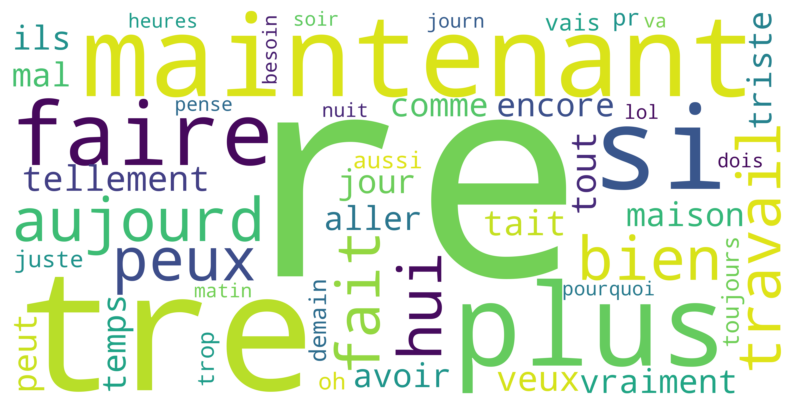

In [ ]:
# Séparer les mots
df_words_0 = df_polarity_0.withColumn("word", explode(col("filtered")))

# Compter les occurrences des mots
df_word_counts_0 = df_words_0.groupBy("word").count().orderBy(col("count").desc()).limit(50)

df_word_cloud_0 = df_word_counts_0.groupBy().agg(array_join(collect_list("word"), " ").alias("text"))

text_content_0 = df_word_cloud_0.collect()[0]["text"]

# Générer le wordcloud
wordcloud_0 = WordCloud(
    scale=10,
    background_color="white",
    stopwords=STOPWORDS,
    random_state=1  # Assure que la sortie soit toujours la même pour la même entrée
).generate(text_content_0)

# Afficher le wordcloud
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.show()

#### Polarity 4

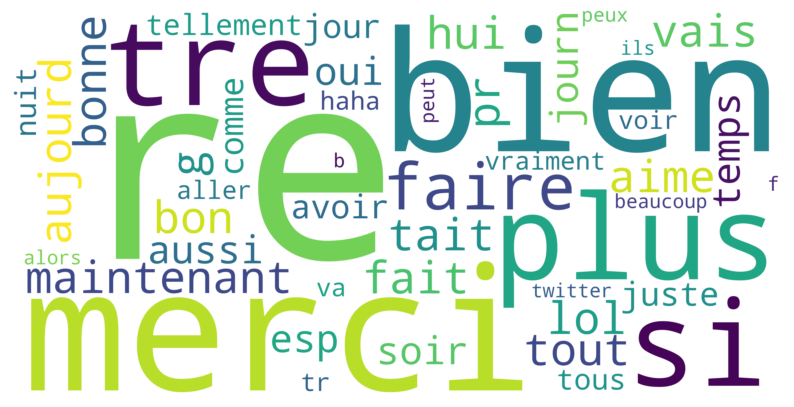

In [ ]:
# Séparer les mots
df_words_4 = df_polarity_4.withColumn("word", explode(col("filtered")))

# Compter les occurrences des mots
df_word_counts_4 = df_words_4.groupBy("word").count().orderBy(col("count").desc()).limit(50)

# Créer une chaîne de mots pour le nuage de mots

df_word_cloud_4 = df_word_counts_4.groupBy().agg(array_join(collect_list("word"), " ").alias("text"))

text_content_4 = df_word_cloud_4.collect()[0]["text"]

# Générer le wordcloud
wordcloud_4 = WordCloud(
    scale=10,
    background_color="white",
    stopwords=STOPWORDS,
    random_state=1  # Assure que la sortie soit toujours la même pour la même entrée
).generate(text_content_4)

# Afficher le wordcloud
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wordcloud_4, interpolation='bilinear')
plt.show()

# Pipeline de nettoyage des données

Pour la préparation des données, on a encore recours aux pipelines. Cela permet de moduler facilement les différentes étapes du code. On défini plusieurs étapes en indiquant la colonne d'entrée et la colonne de sortie, puis on définit la pipeline en indiquant les différentes étapes. Il suffira alors de "fit" la pipeline puis de transformer les jeux de données pour obtenir les prédictions. Elle prend en compte plusieurs parties : 

- Transformation de la variable d'intérêt :  Encodage de la colonne de labels catégoriels en une colonne d'indices numériques
- Pour la partie nettoyage 
    - Utilisation de la bibliothèque pyspark de mots vide version françaises auquel des mots vides ont été ajoutés manuellement car figurant dans les tweets. 
    - RegexTokenizer : permet de spliter le texte de la colonne
- Word embedding
    - CountVectors : transforme la colonne obtenue après avoir enlever les stop words en une nouvelle colonne ou apparaîtra pour chaque message la taille du vocabulaire, ainsi que pour chaque mot du vocabulaire total (on prend tous les messages du dataset), le nombre de fois que le mot est employé. Cela permet de transformer le message en vecteur qui sera interprétable par un algorithme. Par exemple si le message contient plusieurs fois les mots "ne" et "pas", alors il aura plus de chance d'être interprêté comme un message négatif.
    - HashingTF and IDF qui permettent de faire un TF-IDF.
    - Word2Vec qui permet de convertir chaque mot en un vecteur de taille n (à définir). Ainsi il y a maintenant des notions de distance entre les mots.

- Modèles à tester
    - Régression logistique
    - Forêts aléatoire (randon forest)
    - Modèle Naïve
    - Support Vecteur Machine (SVM)
    - Gradient Boosting

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Extraction des caractéristiques

## Transformation de la variable d'intérêt

In [18]:
# StringIndexer: encode une colonne de labels en une colonne d'indices numériques
label_stringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")

## Extraction des caractéristiques

In [19]:
# TF-IDF
# HashingTF: utilise le "hashing trick" pour convertir une collection de mots en un vecteur de features de taille fixe
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)

# IDF: pondère les features extraites par le TF-IDF (Term Frequency-Inverse Document Frequency)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

In [20]:
# Word2Vec: crée une représentation vectorielle des mots
w2v = Word2Vec(inputCol= 'filtered', outputCol= 'features', vectorSize= 100)

In [21]:
# CountVectorizer: convertit une collection de documents texte en une matrice de dénombrement de mots
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

## Modèle à tester

In [22]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, LinearSVC, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [23]:
# LogisticRegression: modèle de régression logistique pour la classification
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="label")

# RandomForestClassifier: modèle de classification utilisant un ensemble de plusieurs arbres de décision (forêt aléatoire)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# NaiveBayes: modèle de classification basé sur le théorème de Bayes avec une hypothèse naïve d'indépendance entre les features
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="label", featuresCol="features")

# SVM
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="label", featuresCol="features")

# Gradient-boosted tree classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

Pour chacune des transformations possibles, nous allons tester les différents modèles et apprécier les erreurs d'apprentissage et de test
# Modèle avec un vecteur d'occurence

In [ ]:
predictions = {}

models = [lr, rf, nb, lsvc, gbt]

# Ajouter le nom du modèle SVM à la liste des noms de modèles
name_models = ['logistic_regression', 'random_forest', 'naive_bayes', 'svm', 'gradient_boosting']

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Utiliser la boucle pour entraîner et évaluer chaque modèle
for i, model in enumerate(models):

    # Créer le pipeline avec les étapes définies, y compris le modèle actuel
    pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, model])

    # Entraîner le pipeline sur les données d'entraînement
    mod = pipeline.fit(df_train)

    # Faire des prédictions sur les données d'entraînement et de test
    prediction_train = mod.transform(df_train)
    prediction_test = mod.transform(df_test)

    # Sauvegarder les prédictions dans le dictionnaire
    predictions['prediction_train_%s_%s' % (name_models[i], 'CountVectorizer')] = prediction_train
    predictions['prediction_test_%s_%s' % (name_models[i], 'CountVectorizer')] = prediction_test

    # Afficher les scores du modèle sur les données d'entraînement et de test
    print("\nNom du modèle utilisé : %s" % (name_models[i]))
    print("Score sur les données d'entraînement : %.3f" % (evaluator.evaluate(prediction_train)))
    print("Score sur les données test : %.3f \n" % (evaluator.evaluate(prediction_test)))


Nom du modèle utilisé : logistic_regression
Score sur les données d'entraînement : 0.357
Score sur les données test : 0.355 


Nom du modèle utilisé : random_forest
Score sur les données d'entraînement : 0.506
Score sur les données test : 0.500 


Nom du modèle utilisé : naive_bayes
Score sur les données d'entraînement : 0.784
Score sur les données test : 0.758 


Nom du modèle utilisé : svm
Score sur les données d'entraînement : 0.802
Score sur les données test : 0.757 


Nom du modèle utilisé : gradient_boosting
Score sur les données d'entraînement : 0.601
Score sur les données test : 0.591 



In [ ]:
predictions['prediction_test_svm_CountVectorizer'] \
    .select("message","label","prediction") \
    .show(10, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|message                                                                                                                                                |label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|! Et si affamé mais pas de soucis maman cuisine la Turquie aujourd'hui                                                                                 |1.0  |1.0       |
|! Identica présente actuellement des problèmes assez graves concernant la performance la disponibilité et sa passerelle vers Twitter. ! Laconica       |1.0  |1.0       |
|! Je vais enfin m'endormir pour pouvoir échouer mon test de psychologie demain soir.                                                            

# Avec un TF-IDF

In [28]:
predictions = {}

# Ajouter le modèle SVM à la liste des modèles
models = [lr, rf, nb, lsvc, gbt]

# Ajouter le nom du modèle SVM à la liste des noms de modèles
name_models = ['logistic_regression', 'random_forest', 'naive_bayes', 'svm', 'gradient_boosting']

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Utiliser la boucle pour entraîner et évaluer chaque modèle
for i, model in enumerate(models):

    # Créer le pipeline avec les étapes définies, y compris le modèle actuel
    pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx, model])

    # Entraîner le pipeline sur les données d'entraînement
    mod = pipeline.fit(df_train)

    # Faire des prédictions sur les données d'entraînement et de test
    prediction_train = mod.transform(df_train)
    prediction_test = mod.transform(df_test)

    # Sauvegarder les prédictions dans le dictionnaire
    predictions['prediction_train_%s_%s' % (name_models[i], 'tf_idf')] = prediction_train
    predictions['prediction_test_%s_%s' % (name_models[i], 'tf_idf')] = prediction_test

    # Afficher les scores du modèle sur les données d'entraînement et de test
    print("\nNom du modèle utilisé : %s" % (name_models[i]))
    print("Score sur les données d'entraînement : %.3f" % (evaluator.evaluate(prediction_train)))
    print("Score sur les données test : %.3f \n" % (evaluator.evaluate(prediction_test)))


Nom du modèle utilisé : logistic_regression
Score sur les données d'entraînement : 0.357
Score sur les données test : 0.355 


Nom du modèle utilisé : random_forest
Score sur les données d'entraînement : 0.513
Score sur les données test : 0.510 


Nom du modèle utilisé : naive_bayes
Score sur les données d'entraînement : 0.764
Score sur les données test : 0.726 


Nom du modèle utilisé : svm
Score sur les données d'entraînement : 0.783
Score sur les données test : 0.735 


Nom du modèle utilisé : gradient_boosting
Score sur les données d'entraînement : 0.612
Score sur les données test : 0.602 



In [29]:
predictions['prediction_test_svm_tf_idf'] \
    .select("message","label","prediction") \
    .show(10, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|message                                                                                                                                                |label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|! Et si affamé mais pas de soucis maman cuisine la Turquie aujourd'hui                                                                                 |1.0  |0.0       |
|! Identica présente actuellement des problèmes assez graves concernant la performance la disponibilité et sa passerelle vers Twitter. ! Laconica       |1.0  |0.0       |
|! Je vais enfin m'endormir pour pouvoir échouer mon test de psychologie demain soir.                                                            

# Avec un word2Vec

In [30]:
predictions = {}

# Ajouter le modèle SVM à la liste des modèles
models = [lr, rf, lsvc, gbt]

# Ajouter le nom du modèle SVM à la liste des noms de modèles
name_models = ['logistic_regression', 'random_forest', 'svm', 'gradient_boosting']

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Utiliser la boucle pour entraîner et évaluer chaque modèle
for i, model in enumerate(models):

    # Créer le pipeline avec les étapes définies, y compris le modèle actuel
    pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, w2v, label_stringIdx, model])

    # Entraîner le pipeline sur les données d'entraînement
    mod = pipeline.fit(df_train)

    # Faire des prédictions sur les données d'entraînement et de test
    prediction_train = mod.transform(df_train)
    prediction_test = mod.transform(df_test)

    # Sauvegarder les prédictions dans le dictionnaire
    predictions['prediction_train_%s_%s' % (name_models[i], 'w2vec')] = prediction_train
    predictions['prediction_test_%s_%s' % (name_models[i], 'w2vec')] = prediction_test

    # Afficher les scores du modèle sur les données d'entraînement et de test
    print("\nNom du modèle utilisé : %s" % (name_models[i]))
    print("Score sur les données d'entraînement : %.3f" % (evaluator.evaluate(prediction_train)))
    print("Score sur les données test : %.3f \n" % (evaluator.evaluate(prediction_test)))



Nom du modèle utilisé : logistic_regression
Score sur les données d'entraînement : 0.357
Score sur les données test : 0.355 


Nom du modèle utilisé : random_forest
Score sur les données d'entraînement : 0.648
Score sur les données test : 0.642 


Nom du modèle utilisé : svm
Score sur les données d'entraînement : 0.668
Score sur les données test : 0.664 


Nom du modèle utilisé : gradient_boosting
Score sur les données d'entraînement : 0.661
Score sur les données test : 0.650 



In [31]:
predictions['prediction_test_svm_w2vec'] \
    .select("message","label","prediction") \
    .show(10, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|message                                                                                                                                                |label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|! Et si affamé mais pas de soucis maman cuisine la Turquie aujourd'hui                                                                                 |1.0  |1.0       |
|! Identica présente actuellement des problèmes assez graves concernant la performance la disponibilité et sa passerelle vers Twitter. ! Laconica       |1.0  |0.0       |
|! Je vais enfin m'endormir pour pouvoir échouer mon test de psychologie demain soir.                                                            

# Optimisation de modèle

Afin d'améliorer encore le score en prédiction, nous pouvons utiliser la cross validation. Pour ce faire, nous utiliserons les fonctions ParamGridBuilder et CrossValidator de pyspark. Nous ferons une grid search seulement pour la regression logistique et la classification naïve bayésienne, pour un embedding via count vectorizer

In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## SVM Optimiser

In [33]:
svm = LinearSVC(maxIter=10)

# Créer le pipeline pour le modèle SVM
pipeline_svm = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, svm])

# Définir la grille de paramètres pour le modèle SVM
paramGrid_svm = (ParamGridBuilder()
                 .addGrid(svm.maxIter, [10, 50, 100])
                 .addGrid(svm.regParam, [0.1, 0.01])
                 .build())

# Créer l'évaluateur pour le modèle SVM
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Créer un validateur croisé pour le modèle SVM
cv_svm = CrossValidator(estimator=pipeline_svm,
                        estimatorParamMaps=paramGrid_svm,
                        evaluator=evaluator,
                        numFolds=10)

# Ajuster le modèle SVM avec la validation croisée
cvModel_svm = cv_svm.fit(df_train)

# Faire des prédictions sur les données d'entraînement et de test avec le meilleur modèle SVM
predictions_train_svm = cvModel_svm.transform(df_train)
predictions_test_svm = cvModel_svm.transform(df_test)

# Afficher les scores du modèle SVM sur les données d'entraînement et de test
print("\nNom du modèle utilisé : SVM")
print("Score sur les données d'entraînement : %.3f" % (evaluator.evaluate(predictions_train_svm)))
print("Score sur les données test : %.3f" % (evaluator.evaluate(predictions_test_svm)))



Nom du modèle utilisé : SVM
Score sur les données d'entraînement : 0.802
Score sur les données test : 0.757


In [34]:
# Obtenir les paramètres optimaux du modèle SVM
best_pipeline_svm = cvModel_svm.bestModel
best_model_svm = best_pipeline_svm.stages[-1]  # Obtenir le dernier élément du pipeline (le modèle SVM)
best_params_svm = best_model_svm.extractParamMap()

# Afficher les paramètres optimaux du modèle SVM
print("Paramètres optimaux du modèle SVM :")
for param, value in best_params_svm.items():
    print(param.name, ":", value)


Paramètres optimaux du modèle SVM :
aggregationDepth : 2
featuresCol : features
fitIntercept : True
labelCol : label
maxBlockSizeInMB : 0.0
maxIter : 10
predictionCol : prediction
rawPredictionCol : rawPrediction
regParam : 0.1
standardization : True
threshold : 0.0
tol : 1e-06


## Logistic Optimiser

In [ ]:
import numpy as np

lr = LogisticRegression()
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, lr])
vectC = np.logspace(-3, -2, 20)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, vectC)
             .addGrid(lr.elasticNetParam, [0.1, 0.15])
             .build())

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

cv = CrossValidator(estimator=pipeline, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=10)
cvModel_lr = cv.fit(df_train)

predictions_test = cvModel_lr.transform(df_test)
predictions_train = cvModel_lr.transform(df_train)
print("\nNom du modèle utilisé : logistic regression")
print("Score sur les données d'entraînement : %.3f" %(evaluator.evaluate(predictions_train)))
print("Score sur les données test : %.3f \n" %(evaluator.evaluate(predictions_test)))


Nom du modèle utilisé : logistic regression
Score sur les données d'entraînement : 0.795
Score sur les données test : 0.760 



In [ ]:
# Obtenir les paramètres optimaux du modèle de régression logistique
best_pipeline_lr = cvModel_lr.bestModel
best_model_lr = best_pipeline_lr.stages[-1]  # Obtenir le dernier élément du pipeline (le modèle de régression logistique)
best_params_lr = best_model_lr.extractParamMap()

# Afficher les paramètres optimaux du modèle de régression logistique
print("Paramètres optimaux du modèle de régression logistique :")
for param, value in best_params_lr.items():
    print(param.name, ":", value)


Paramètres optimaux du modèle de régression logistique :
aggregationDepth : 2
elasticNetParam : 0.1
family : auto
featuresCol : features
fitIntercept : True
labelCol : label
maxBlockSizeInMB : 0.0
maxIter : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
regParam : 0.01
standardization : True
threshold : 0.5
tol : 1e-06


### Optimiser le modèle Naive

In [ ]:
import numpy as np

nb = NaiveBayes(modelType="multinomial")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, nb])
paramGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0,1,2,5,10])
             .build())

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

cv = CrossValidator(estimator=pipeline, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=10)
cvModel_nb = cv.fit(df_train)

predictions_test = cvModel_nb.transform(df_test)
predictions_train = cvModel_nb.transform(df_train)
print("\nNom du modèle utilisé : naive bayes")
print("Score sur les données d'entraînement : %.3f" %(evaluator.evaluate(predictions_train)))
print("Score sur les données test : %.3f" %(evaluator.evaluate(predictions_test)))


Nom du modèle utilisé : naive bayes
Score sur les données d'entraînement : 0.781
Score sur les données test : 0.757


In [ ]:
# Obtenir les paramètres optimaux du modèle Naive Bayes
best_pipeline_nb = cvModel_nb.bestModel
best_model_nb = best_pipeline_nb.stages[-1]  # Obtenir le dernier élément du pipeline (le modèle Naive Bayes)
best_params_nb = best_model_nb.extractParamMap()

# Afficher les paramètres optimaux du modèle Naive Bayes
print("Paramètres optimaux du modèle Naive Bayes :")
for param, value in best_params_nb.items():
    print(param.name, ":", value)


Paramètres optimaux du modèle Naive Bayes :
featuresCol : features
labelCol : label
modelType : multinomial
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
smoothing : 5.0


# Prédiction des éléments dans NoClass

In [36]:
df_noclass = spark.read.json("/content/gdrive/MyDrive/Spark/noclass.json")
df_noclass.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|message                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|"Dans ganga" Ne veux-tu pas dire "à gaga" Oh bien..club [v] !! Mes frères à un 18e et je suis coincé à la maison                                                               |
|"Dieu elton" vous ne pouvez pas sucer?! & Quot; Moi non plus mais je peux essayer? Ça me manque comme si j'avais l'impression que les troubles de l'alimentation sont les      |
|"I was up up the half the night essayant d'installer vista & quot; N'est pas une raison d'être fatigué que je

In [38]:
predictions_noclass = cvModel_svm.transform(df_test).select("message","prediction")
predictions_noclass = predictions_noclass.withColumn("prediction", predictions_noclass["prediction"].cast('string'))

In [39]:
from pyspark.ml.feature import IndexToString

# Convertir la colonne de prédiction en type numérique
predictions_noclass = predictions_noclass.withColumn("prediction", col("prediction").cast("double"))

# Définir l'indexeur de chaîne inversé
label_converter = IndexToString(inputCol="prediction", outputCol="originalPolarity", labels=['0', '4'])

# Appliquer l'indexeur de chaîne inversé aux prédictions
predictions_noclass = label_converter.transform(predictions_noclass)

In [40]:
# Afficher les prédictions avec les libellés prédits
predictions_noclass.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------------+
|message                                                                                                                                                                      |prediction|originalPolarity|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------------+
|! Et si affamé mais pas de soucis maman cuisine la Turquie aujourd'hui                                                                                                       |1.0       |4               |
|! Identica présente actuellement des problèmes assez graves concernant la performance la disponibilité et sa passerelle vers Twitter. ! Laconica                             |1.0      

In [44]:
predictions_noclass = predictions_noclass.select("message", "originalPolarity")
predictions_noclass.show()

+--------------------+----------------+
|             message|originalPolarity|
+--------------------+----------------+
|! Et si affamé ma...|               4|
|! Identica présen...|               4|
|! Je vais enfin m...|               4|
|!?!? C'est un jou...|               4|
|"Easy" qu Le plan...|               4|
|"Empire du soleil...|               4|
|"Heart" quot; N'e...|               4|
|"I need" & quot; ...|               4|
|"Ils ont trouvé s...|               0|
|"Je vérifie mon t...|               0|
|"Recevoir un préa...|               4|
|"Statut sélectif ...|               4|
|"Sur la musique p...|               4|
|"The dating exper...|               0|
|& Amp; Tout le re...|               4|
|& Gt; Le frère es...|               4|
|& Gt; Que cela im...|               0|
|& Gt; __ & lt; Je...|               0|
|& Lt; & lt; -----...|               4|
|& Lt; --- ne peut...|               0|
+--------------------+----------------+
only showing top 20 rows



In [45]:
# Sauvegarder les éléments de prédiction dans un fichier JSON
predictions_noclass.coalesce(1).write.format('json').save('noclass_pred.json')

In [46]:
spark.stop()